<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-sets" data-toc-modified-id="Data-sets-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data sets</a></span><ul class="toc-item"><li><span><a href="#Data-without-unobservables" data-toc-modified-id="Data-without-unobservables-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data without unobservables</a></span></li><li><span><a href="#Synthetic-data-with-unobservables" data-toc-modified-id="Synthetic-data-with-unobservables-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Synthetic data with unobservables</a></span></li></ul></li><li><span><a href="#Algorithms" data-toc-modified-id="Algorithms-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Algorithms</a></span><ul class="toc-item"><li><span><a href="#Contraction-algorithm" data-toc-modified-id="Contraction-algorithm-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Contraction algorithm</a></span></li><li><span><a href="#Causal-approach---metrics" data-toc-modified-id="Causal-approach---metrics-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Causal approach - metrics</a></span></li></ul></li><li><span><a href="#Performance-comparison" data-toc-modified-id="Performance-comparison-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Performance comparison</a></span><ul class="toc-item"><li><span><a href="#Without-unobservables-in-the-data" data-toc-modified-id="Without-unobservables-in-the-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Without unobservables in the data</a></span></li><li><span><a href="#With-unobservables-in-the-data" data-toc-modified-id="With-unobservables-in-the-data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>With unobservables in the data</a></span></li></ul></li></ul></div>

<!-- ##  Causal model

Our model is defined by the probabilistic expression 

\begin{equation} \label{model_disc}
P(Y=0 | \text{do}(R=r)) = \sum_x \underbrace{P(Y=0|X=x, T=1)}_\text{1} 
\overbrace{P(T=1|R=r, X=x)}^\text{2} 
\underbrace{P(X=x)}_\text{3}
\end{equation}

which is equal to 

\begin{equation}\label{model_cont}
P(Y=0 | \text{do}(R=r)) = \int_x P(Y=0|X=x, T=1)P(T=1|R=r, X=x)P(X=x)
\end{equation}

for continuous $x$. In the model Z is a latent, unobserved variable, and can be excluded from the expression with do-calculus by showing that $X$ is admissible for adjustment. Model as a graph:

![Model as picture](../figures/intervention_model.png "Intervention model")

For predicting the probability of negative outcome the following should hold because by Pearl $P(Y=0 | \text{do}(R=r), X=x) = P(Y=0 | R=r, X=x)$ when $X$ is an admissible set:

\begin{equation} \label{model_pred}
P(Y=0 | \text{do}(R=r), X=x) = P(Y=0|X=x, T=1)P(T=1|R=r, X=x).
\end{equation}

Still it should be noted that this prediction takes into account the probability of the individual to be given a positive decision ($T=1$), see second term in \ref{model_pred}.

----

### Notes

* Equations \ref{model_disc} and \ref{model_cont} describe the whole causal effect in the population (the causal effect of changing $r$ over all strata $X$).
* Prediction should be possible with \ref{model_pred}. Both terms can be learned from the data. NB: the probability $P(Y=0 | \text{do}(R=r), X=x)$ is lowest when the individual $x$ is the most dangerous or the least dangerous. How could we infer/predict the counterfactual "what is the probability of $Y=0$ if we were to let this individual go?" has yet to be calculated.
* Is the effect of R learned/estimated correctly if it is just plugged in to a predictive model (e.g. logistic regression)? **NO**
* $P(Y=0 | do(R=0)) = 0$ only in this application. <!-- My predictive models say that when $r=0$ the probability $P(Y=0) \approx 0.027$ which would be a natural estimate in another application/scenario (e.g. in medicine the probability of an adverse event when a stronger medicine is distributed to everyone. Then the probability will be close to zero but not exactly zero.) -->

Imports and settings.

In [1]:
# Imports

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.stats as scs
import scipy.integrate as si
import seaborn as sns
import numpy.random as npr
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Settings

%matplotlib inline

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'figure.figsize': (10, 6)})

# Suppress deprecation warnings.

import warnings


def fxn():
    warnings.warn("deprecated", DeprecationWarning)


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

## Data sets

### Data without unobservables

In the chunk below, we generate a simplified data. The default values and definitions of $Y$ and $T$ values follow the previous description.

**Parameters**

* M = `nJudges_M`, number of judges
* N = `nSubjects_N`, number of subjects assigned to each judge
* $\beta_X$ = `beta_X`, coefficient for $X$

**Columns of the data:**

* `judgeID_J` = judge IDs as running numbering from 0 to `nJudges_M - 1`
* R = `acceptanceRate_R`, acceptance rates
* X = `X`, invidual's features observable to all (models and judges), now $X \sim \mathcal{N}(0, 1)$
* T = `decision_T`, bail-or-jail decisions where $T=0$ represents jail decision and $T=1$ bail decision.
* $p_y$ = `probabilities_Y`, variable where $p_y = P(Y=0)$
* Y = `result_Y`, result variable, if $Y=0$ person will or would recidivate and if $Y=1$ person will or would not commit a crime. Here $Y \sim \text{Bernoulli}(\frac{1}{1+exp\{-X\}})$

In [12]:
def dataWithoutUnobservables(nJudges_M=100,
                             nSubjects_N=500,
                             sigma=0.0):

    df = pd.DataFrame()

    # Assign judge IDs as running numbering from 0 to nJudges_M - 1
    df = df.assign(judgeID_J=np.repeat(range(0, nJudges_M), nSubjects_N))

    # Sample acceptance rates uniformly from a closed interval
    # from 0.1 to 0.9 and round to tenth decimal place.
    acceptance_rates = np.round(npr.uniform(.1, .9, nJudges_M), 10)

    # Replicate the rates so they can be attached to the corresponding judge ID.
    df = df.assign(acceptanceRate_R=np.repeat(acceptance_rates, nSubjects_N))

    # Sample feature X from standard Gaussian distribution, N(0, 1).
    df = df.assign(X=npr.normal(size=nJudges_M * nSubjects_N))

    # Calculate P(Y=0|X=x) = 1 / (1 + exp(-X)) = sigmoid(X)
    df = df.assign(probabilities_Y=sigmoid(df.X))

    # Draw Y ~ Bernoulli(1 - sigmoid(X))
    # Note: P(Y=1|X=x) = 1 - P(Y=0|X=x) = 1 - sigmoid(X)
    results = npr.binomial(n=1, p=1 - df.probabilities_Y,
                           size=nJudges_M * nSubjects_N)

    df = df.assign(result_Y=results)

    # Assign the prediction probabilities and add some Gaussian noise
    # if sigma is set to != 0.
    df = df.assign(probabilities_T=df.probabilities_Y)

    df.probabilities_T += npr.normal(size=nJudges_M * nSubjects_N) * sigma

    # Sort by judges then probabilities in decreasing order
    # I.e. the most dangerous for each judge are first.
    df.sort_values(by=["judgeID_J", "probabilities_T"],
                   ascending=False,
                   inplace=True)

    # Iterate over the data. Subject is in the top (1-r)*100% if
    # his within-judge-index is over acceptance threshold times
    # the number of subjects assigned to each judge. If subject
    # is over the limit they are assigned a zero, else one.
    df.reset_index(drop=True, inplace=True)

    df['decision_T'] = np.where((df.index.values % nSubjects_N) <
                                ((1 - df['acceptanceRate_R']) * nSubjects_N),
                                0, 1)

    # Halve the data set to test and train
    train, test = train_test_split(df, test_size=0.5)

    train_labeled = train.copy()
    test_labeled = test.copy()

    # Set results as NA if decision is negative.
    train_labeled.loc[train_labeled.decision_T == 0, 'result_Y'] = np.nan
    test_labeled.loc[test_labeled.decision_T == 0, 'result_Y'] = np.nan

    return train_labeled, train, test_labeled, test, df

### Synthetic data with unobservables

In the chunk below, we generate the synthetic data as described by Lakkaraju et al. The default values and definitions of $Y$ and $T$ values follow their description.

**Parameters**

* M = `nJudges_M`, number of judges
* N = `nSubjects_N`, number of subjects assigned to each judge
* betas $\beta_i$ = `beta_i`, where $i \in \{X, Z, W\}$ are coefficients for the respected variables

**Columns of the data:**

* `judgeID_J` = judge IDs as running numbering from 0 to `nJudges_M - 1`
* R = `acceptanceRate_R`, acceptance rates
* X = `X`, invidual's features observable to all (models and judges)
* Z = `Z`, information observable for judges only
* W = `W`, unobservable / inaccessible information
* T = `decision_T`, bail-or-jail decisions where $T=0$ represents jail decision and $T=1$ bail decision.
* Y = `result_Y`, result variable, if $Y=0$ person will or would recidivate and if $Y=1$ person will or would not commit a crime.

The generated data will have M\*N rows.

In [2]:
def sigmoid(x):
    '''Return value of sigmoid function (inverse of logit) at x.'''

    return 1 / (1 + np.exp(-1*x))


def dataWithUnobservables(nJudges_M=100,
                          nSubjects_N=500,
                          beta_X=1.0,
                          beta_Z=1.0,
                          beta_W=0.2):

    df = pd.DataFrame()

    # Assign judge IDs as running numbering from 0 to nJudges_M - 1
    df = df.assign(judgeID_J=np.repeat(range(0, nJudges_M), nSubjects_N))

    # Sample acceptance rates uniformly from a closed interval
    # from 0.1 to 0.9 and round to tenth decimal place.
    acceptance_rates = np.round(npr.uniform(.1, .9, nJudges_M), 10)

    # Replicate the rates so they can be attached to the corresponding judge ID.
    df = df.assign(acceptanceRate_R=np.repeat(acceptance_rates, nSubjects_N))

    # Sample the variables from standard Gaussian distributions.
    df = df.assign(X=npr.normal(size=nJudges_M * nSubjects_N))
    df = df.assign(Z=npr.normal(size=nJudges_M * nSubjects_N))
    df = df.assign(W=npr.normal(size=nJudges_M * nSubjects_N))

    # Calculate P(Y=0|X, Z, W)
    probabilities_Y = sigmoid(beta_X * df.X + beta_Z * df.Z + beta_W * df.W)

    df = df.assign(probabilities_Y=probabilities_Y)

    # Result is 0 if P(Y = 0| X = x; Z = z; W = w) >= 0.5 , 1 otherwise
    df = df.assign(result_Y=np.where(df.probabilities_Y >= 0.5, 0, 1))

    # For the conditional probabilities of T we add noise ~ N(0, 0.1)
    probabilities_T = sigmoid(beta_X * df.X + beta_Z * df.Z)
    probabilities_T += np.sqrt(0.1) * npr.normal(size=nJudges_M * nSubjects_N)

    df = df.assign(probabilities_T=probabilities_T)

    # Sort by judges then probabilities in decreasing order
    # Most dangerous for each judge are at the top.
    df.sort_values(by=["judgeID_J", "probabilities_T"],
                   ascending=False,
                   inplace=True)

    # Iterate over the data. Subject will be given a negative decision
    # if they are in the top (1-r)*100% of the individuals the judge will judge.
    # I.e. if their within-judge-index is under 1 - acceptance threshold times
    # the number of subjects assigned to each judge they will receive a
    # negative decision.
    df.reset_index(drop=True, inplace=True)

    df['decision_T'] = np.where((df.index.values % nSubjects_N) <
                                ((1 - df['acceptanceRate_R']) * nSubjects_N),
                                0, 1)

    # Halve the data set to test and train
    train, test = train_test_split(df, test_size=0.5)

    train_labeled = train.copy()
    test_labeled = test.copy()

    # Set results as NA if decision is negative.
    train_labeled.loc[train_labeled.decision_T == 0, 'result_Y'] = np.nan
    test_labeled.loc[test_labeled.decision_T == 0, 'result_Y'] = np.nan

    return train_labeled, train, test_labeled, test, df

## Algorithms

### Contraction algorithm

Below is an implementation of Lakkaraju's team's algorithm presented in [their paper](https://helka.finna.fi/PrimoRecord/pci.acm3098066). Relevant parameters to be passed to the function are presented in the description.

In [14]:
def contraction(df, judgeIDJ_col, decisionT_col, resultY_col, modelProbS_col,
                accRateR_col, r):
    '''
    This is an implementation of the algorithm presented by Lakkaraju
    et al. in their paper "The Selective Labels Problem: Evaluating 
    Algorithmic Predictions in the Presence of Unobservables" (2017).

    Arguments:
    -----------
    df -- The (Pandas) data frame containing the data, judge decisions,
        judge IDs, results and probability scores.
    judgeIDJ_col -- String, the name of the column containing the judges' IDs
        in df.
    decisionT_col -- String, the name of the column containing the judges' decisions
    resultY_col -- String, the name of the column containing the realization
    modelProbS_col -- String, the name of the column containing the probability
        scores from the black-box model B.
    accRateR_col -- String, the name of the column containing the judges' 
        acceptance rates
    r -- Float between 0 and 1, the given acceptance rate.

    Returns:
    --------
    (1) The estimated failure rate at acceptance rate r.
    '''
    # Get ID of the most lenient judge.
    most_lenient_ID_q = df[judgeIDJ_col].loc[df[accRateR_col].idxmax()]

    # Subset. "D_q is the set of all observations judged by q."
    D_q = df[df[judgeIDJ_col] == most_lenient_ID_q].copy()

    # All observations of R_q have observed outcome labels.
    # "R_q is the set of observations in D_q with observed outcome labels."
    R_q = D_q[D_q[decisionT_col] == 1].copy()

    # Sort observations in R_q in descending order of confidence scores S and
    # assign to R_sort_q.
    # "Observations deemed as high risk by B are at the top of this list"
    R_sort_q = R_q.sort_values(by=modelProbS_col, ascending=False)

    number_to_remove = int(
        round((1.0 - r) * D_q.shape[0] - (D_q.shape[0] - R_q.shape[0])))

    # "R_B is the list of observations assigned to t = 1 by B"
    R_B = R_sort_q[number_to_remove:R_sort_q.shape[0]]

    return np.sum(R_B[resultY_col] == 0) / D_q.shape[0]

### Causal approach - metrics

Generalized performance:

$$
\mathbf{gp} = \sum_{x\in\mathcal{X}}  f(x) ~ \delta(F(x) < r)P(X=x)
$$

and empirical performance:

$$
\mathbf{ep} = \dfrac{1}{n} \sum_{(x, y) \in \mathcal{D}_{test}} f(x) ~ \delta(F(x) < r)
$$

where

$$
f(x) = P(Y=0|T=1, X=x)
$$

is a predictive model trained on the labeled data and

$$
F(x_0) = \int P(x)~\delta(P(Y=0|T=1, X=x) > P(Y=0|T=1, X=x_0)) ~ dx = \int P(x)~\delta(f(x) > f(x_0)) ~ dx.
$$

NB: in code the direction of inequality was changed. CDF changed to `bailIndicator` algorithm.

**Rationale for `bailIndicator`:**

* Bail decision is based on prediction $P(Y=0|T=1, X=x)$.
    * Uniform over all judges
* Judges rationing: "If this defendant is in the top 10% of 'dangerousness rank' and my $r = 0.85$, I will jail him."
* Overall: this kind of defendant $(X=x)$ is usually in the $z^{th}$ percentile in dangerousness (sd $\pm~u$ percentiles). Now, what is the probability that this defendant has $z \leq 1-r$?


<!--- **Proposal**

1. Train model for $P(Y=0|T=1, X=x)$
* Estimate quantile function for $P(T=1|R=r, X=x)$
* Calculate $P(Y=0|do(r'), do(x'))=P(Y=0|T=1, X=x') \cdot P(T=1|R=r', X=x')$ for all instances of the training data
* Order in ascending order based on the probabilities obtained from previous step
* Calculate $$\dfrac{\sum_{i=0}^{r\cdot |\mathcal{D}_{all}|}}{|\mathcal{D}_{all}|}$$--->

In [22]:
def getProbabilityForClass(x, model, class_value):
    '''
    Function (wrapper) for obtaining the probability of a class given x and a 
    predictive model.

    Arguments:
    -----------
    x -- individual features, an array of shape (observations, features)
    model -- a trained sklearn model. Predicts probabilities for given x. 
        Should accept input of shape (observations, features)
    class_value -- the resulting class to predict (usually 0 or 1).

    Returns:
    --------
    (1) The probabilities of given class label for each x.
    '''
    if x.ndim == 1:
        # if x is vector, transform to column matrix.
        f_values = model.predict_proba(np.array(x).reshape(-1, 1))
    else:
        f_values = model.predict_proba(x)

    # Get correct column of predicted class, remove extra dimensions and return.
    return f_values[:, model.classes_ == class_value].flatten()


def cdf(x_0, model, class_value):
    '''
    Cumulative distribution function as described above. Integral is 
    approximated using Simpson's rule for efficiency.
    
    Arguments:
    ----------
    
    x_0 -- private features of an instance for which the value of cdf is to be
        calculated.
    model -- a trained sklearn model. Predicts probabilities for given x. 
        Should accept input of shape (observations, features)
    class_value -- the resulting class to predict (usually 0 or 1).

    '''
    def prediction(x): return getProbabilityForClass(
        np.array([x]).reshape(-1, 1), model, class_value)

    prediction_x_0 = prediction(x_0)

    x_values = np.linspace(-15, 15, 40000)

    x_preds = prediction(x_values)

    y_values = scs.norm.pdf(x_values)

    results = np.zeros(x_0.shape[0])

    for i in range(x_0.shape[0]):

        y_copy = y_values.copy()

        y_copy[x_preds > prediction_x_0[i]] = 0

        results[i] = si.simps(y_copy, x=x_values)

    return results


def bailIndicator(r, y_model, x_train, x_test):
    '''
    Indicator function for whether a judge will bail or jail a suspect.
    Rationale explained above.

    Algorithm:
    ----------

    (1) Calculate recidivism probabilities from training set with a trained 
        model and assign them to predictions_train.

    (2) Calculate recidivism probabilities from test set with the trained 
        model and assign them to predictions_test.

    (3) Construct a quantile function of the probabilities in
        in predictions_train.

    (4)
    For pred in predictions_test:

        if pred belongs to a percentile (computed from step (3)) lower than r
            return True
        else
            return False

    Arguments:
    ----------

    r -- float, acceptance rate, between 0 and 1
    y_model -- a trained sklearn predictive model to predict the outcome
    x_train -- private features of the training instances
    x_test -- private features of the test instances

    Returns:
    --------
    (1) Boolean list indicating a bail decision (bail = True) for each 
        instance in x_test.
    '''

    predictions_train = getProbabilityForClass(x_train, y_model, 0)

    predictions_test = getProbabilityForClass(x_test, y_model, 0)

    return [
        scs.percentileofscore(predictions_train, pred, kind='weak') < r
        for pred in predictions_test
    ]


def estimatePercentiles(x_train, y_model, N_bootstraps=2000, N_sample=100):
    '''
    Estimate percentiles based on bootstrapped samples of original data.
    Bootstrapping is done N_bootstraps times and size of the sample is
    N_sample.


    '''

    res = np.zeros((N_bootstraps, 101))

    percs = np.arange(101)

    for i in range(N_bootstraps):

        sample = npr.choice(x_train, size=N_sample)

        predictions_sample = getProbabilityForClass(sample, y_model, 0)

        res[i, :] = np.percentile(predictions_sample, percs)

    return res


def calcReleaseProbabilities(r,
                             x_train,
                             x_test,
                             y_model,
                             N_bootstraps=2000,
                             N_sample=100,
                             percentileMatrix=None):
    '''
    Similar to bailIndicator, but calculates probabilities for bail decisions
    by bootstrapping the data set.

    Returns:
    --------
    (1) Probabilities for positive bail decisions.
    '''

    if percentileMatrix is None:
        percentileMatrix = estimatePercentiles(x_train, y_model, N_bootstraps,
                                               N_sample)

    probs = np.zeros(len(x_test))

    for i in range(len(x_test)):

        if np.isnan(x_test[i]):

            probs[i] = np.nan

        else:

            pred = getProbabilityForClass(x_test[i], y_model, 0)

            probs[i] = np.mean(pred < percentileMatrix[:, r])

    return probs

## Performance comparison

Below we try to replicate the results obtained by Lakkaraju and compare their model's performance to the one of ours.

In [16]:
def fitPredictiveModel(x_train, y_train, x_test, class_value, model_type=None):
    '''
    Fit a predictive model (default logistic regression) with given training 
    instances and return probabilities for test instances to obtain a given 
    class label.
    
    Arguments:
    ----------
    
    x_train -- x values of training instances
    y_train -- y values of training instances
    x_test -- x values of test instances
    class_value -- class label for which the probabilities are counted for.
    model_type -- type of model to be fitted.
    
    Returns:
    --------
    (1) Trained predictive model
    (2) Probabilities for given test inputs for given class.
    '''

    if model_type is None or model_type in ["logistic_regression", "lr"]:
        # Instantiate the model (using the default parameters)
        logreg = LogisticRegression(solver='lbfgs')

        # Check shape and fit the model.
        if x_train.ndim == 1:
            logreg = logreg.fit(x_train.values.reshape(-1, 1), y_train)
        else:
            logreg = logreg.fit(x_train, y_train)

        label_probs_logreg = getProbabilityForClass(x_test, logreg, class_value)

        return logreg, label_probs_logreg
    
    elif model_type in ["random_forest", "rf"]:
        # Instantiate the model 
        forest = RandomForestClassifier(n_estimators=100, max_depth=3)

        # Check shape and fit the model.
        if x_train.ndim == 1:
            forest = forest.fit(x_train.values.reshape(-1, 1), y_train)
        else:
            forest = forest.fit(x_train, y_train)

        label_probs_forest = getProbabilityForClass(x_test, forest, class_value)

        return forest, label_probs_forest
    
    elif model_type == "fully_random":
        
        label_probs = np.ones_like(x_test) / 2
        
        model_object = lambda x: 0.5
        
        return model_object, label_probs
    else:
        raise ValueError("Invalid model_type!", model_type) 

### Without unobservables in the data

The underlying figure is attached to the preliminary paper. When conducting finalization, last analysis should be conducted with a preset random seed.

[1] 0 1 2 3 4 5 6 7 [2] 0 1 2 3 4 5 6 7 [3] 0 1 2 3 4 5 6 7 [4] 0 1 2 3 4 5 6 7 [5] 0 1 2 3 4 5 6 7 [6] 0 1 2 3 4 5 6 7 [7] 0 1 2 3 4 5 6 7 [8] 0 1 2 3 4 5 6 7 

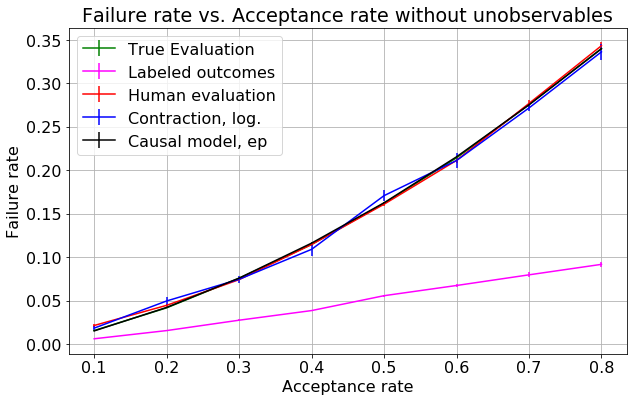

[[0.015455   0.005975   0.02128927 0.01824005 0.01504878]
 [0.041615   0.01541    0.04449708 0.04952796 0.04207918]
 [0.075705   0.02737    0.07408005 0.07451198 0.07586959]
 [0.114615   0.03845    0.11454849 0.1089716  0.11612646]
 [0.161915   0.055585   0.16090506 0.170813   0.16261346]
 [0.214345   0.067335   0.21142173 0.21125308 0.21550736]
 [0.275515   0.079615   0.27699615 0.271816   0.27544641]
 [0.340255   0.091685   0.34350266 0.33641304 0.33994187]]

Mean absolute errors:
0.10724937500000001
0.00238372897518402
0.004633164376337144
0.0005986237333166415


In [24]:
f_rates = np.zeros((8, 5))
f_sems = np.zeros((8, 5))

nIter = 8

#npr.seed(0)

for r in np.arange(1, 9):

    print("[", r, "]", sep='', end=" ")

    s_f_rate_true = np.zeros(nIter)
    s_f_rate_labeled = np.zeros(nIter)
    s_f_rate_human = np.zeros(nIter)
    s_f_rate_cont = np.zeros(nIter)
    s_f_rate_caus = np.zeros(nIter)

    for i in range(nIter):

        print(i, end=" ")

        s_train_labeled, s_train, s_test_labeled, s_test, s_df = dataWithoutUnobservables()

        s_logreg, predictions = fitPredictiveModel(
            s_train_labeled.dropna().X,
            s_train_labeled.dropna().result_Y, s_test.X, 0)
        s_test = s_test.assign(B_prob_0_model=predictions)

        s_logreg, predictions_labeled = fitPredictiveModel(
            s_train_labeled.dropna().X,
            s_train_labeled.dropna().result_Y, s_test_labeled.X, 0)
        s_test_labeled = s_test_labeled.assign(
            B_prob_0_model=predictions_labeled)

        #### True evaluation
        # Sort by actual failure probabilities, subjects with the smallest risk are first.
        s_sorted = s_test.sort_values(by='B_prob_0_model',
                                      inplace=False,
                                      ascending=True)

        to_release = int(round(s_sorted.shape[0] * r / 10))

        # Calculate failure rate as the ratio of failures to successes among those
        # who were given a positive decision, i.e. those whose probability of negative
        # outcome was low enough.
        s_f_rate_true[i] = np.sum(
            s_sorted.result_Y[0:to_release] == 0) / s_sorted.shape[0]

        #### Labeled outcomes
        # Sort by estimated failure probabilities, subjects with the smallest risk are first.
        s_sorted = s_test_labeled.sort_values(by='B_prob_0_model',
                                              inplace=False,
                                              ascending=True)

        to_release = int(round(s_test_labeled.dropna().shape[0] * r / 10))

        # Calculate failure rate as the ratio of failures to successes among those
        # who were given a positive decision, i.e. those whose probability of negative
        # outcome was low enough.
        s_f_rate_labeled[i] = np.sum(
            s_sorted.result_Y[0:to_release] == 0) / s_sorted.shape[0]

        #### Human error rate
        # Get judges with correct leniency as list
        correct_leniency_list = s_test_labeled.judgeID_J[
            s_test_labeled['acceptanceRate_R'].round(1) == r / 10].values

        # Released are the people they judged and released, T = 1
        released = s_test_labeled[
            s_test_labeled.judgeID_J.isin(correct_leniency_list)
            & (s_test_labeled.decision_T == 1)]

        # Get their failure rate, aka ratio of reoffenders to number of people judged in total
        s_f_rate_human[i] = np.sum(
            released.result_Y == 0) / correct_leniency_list.shape[0]

        #### Contraction
        s_f_rate_cont[i] = contraction(s_test_labeled, 'judgeID_J',
                                       'decision_T', 'result_Y',
                                       'B_prob_0_model', 'acceptanceRate_R',
                                       r / 10)
        #### Causal model

        #released = bailIndicator(r * 10, s_logreg, s_train.X, s_test.X)

        released = cdf(s_test.X, s_logreg, 0) < r / 10

        s_f_rate_caus[i] = np.mean(s_test.B_prob_0_model * released)

        ########################
        #percentiles = estimatePercentiles(s_train_labeled.X, s_logreg)

        #def releaseProbability(x):
        #    return calcReleaseProbabilities(r * 10,
        #                                     s_train_labeled.X,
        #                                     x,
        #                                     s_logreg,
        #                                     percentileMatrix=percentiles)

        #def integrand(x):
        #    p_y0 = s_logreg.predict_proba(x.reshape(-1, 1))[:, 0]

        #    p_t1 = releaseProbability(x)

        #    p_x = scs.norm.pdf(x)

        #    return p_y0 * p_t1 * p_x

        #s_f_rate_caus[i] = si.quad(lambda x: integrand(np.ones((1, 1)) * x),
        #                           -10, 10)[0]

    f_rates[r - 1, 0] = np.mean(s_f_rate_true)
    f_rates[r - 1, 1] = np.mean(s_f_rate_labeled)
    f_rates[r - 1, 2] = np.mean(s_f_rate_human)
    f_rates[r - 1, 3] = np.mean(s_f_rate_cont)
    f_rates[r - 1, 4] = np.mean(s_f_rate_caus)

    f_sems[r - 1, 0] = scs.sem(s_f_rate_true)
    f_sems[r - 1, 1] = scs.sem(s_f_rate_labeled)
    f_sems[r - 1, 2] = scs.sem(s_f_rate_human)
    f_sems[r - 1, 3] = scs.sem(s_f_rate_cont)
    f_sems[r - 1, 4] = scs.sem(s_f_rate_caus)

x_ax = np.arange(0.1, 0.9, 0.1)

plt.errorbar(x_ax,
             f_rates[:, 0],
             label='True Evaluation',
             c='green',
             yerr=f_sems[:, 0])
plt.errorbar(x_ax,
             f_rates[:, 1],
             label='Labeled outcomes',
             c='magenta',
             yerr=f_sems[:, 1])
plt.errorbar(x_ax,
             f_rates[:, 2],
             label='Human evaluation',
             c='red',
             yerr=f_sems[:, 2])
plt.errorbar(x_ax,
             f_rates[:, 3],
             label='Contraction, log.',
             c='blue',
             yerr=f_sems[:, 3])
plt.errorbar(x_ax,
             f_rates[:, 4],
             label='Causal model, ep',
             c='black',
             yerr=f_sems[:, 4])

plt.title('Failure rate vs. Acceptance rate without unobservables')
plt.xlabel('Acceptance rate')
plt.ylabel('Failure rate')
plt.legend()
plt.grid()
plt.show()

print(f_rates)
print("\nMean absolute errors:")
for i in range(1, f_rates.shape[1]):
    print(np.mean(np.abs(f_rates[:, 0] - f_rates[:, i])))

### With unobservables in the data

Lakkaraju says that they used logistic regression. We train the predictive models using only *observed observations*, i.e. observations for which labels are available. We then predict the probability of negative outcome for all observations in the test data and attach it to our data set.

[1] 0 1 2 3 4 5 6 7 [2] 0 1 2 3 4 5 6 7 [3] 0 1 2 3 4 5 6 7 [4] 0 1 2 3 4 5 6 7 [5] 0 1 2 3 4 5 6 7 [6] 0 1 2 3 4 5 6 7 [7] 0 1 2 3 4 5 6 7 [8] 0 1 2 3 4 5 6 7 

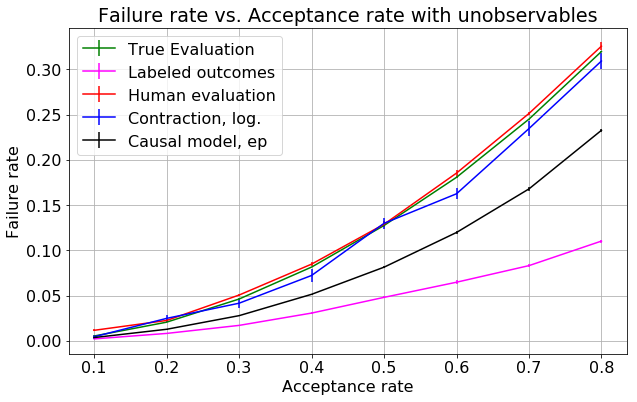

[[0.00543    0.002235   0.01173347 0.00462072 0.00371409]
 [0.02073    0.00829    0.02260202 0.02491425 0.01286922]
 [0.046295   0.01716    0.05069571 0.04167522 0.02791597]
 [0.081615   0.030765   0.0848586  0.0723175  0.05149991]
 [0.12755    0.048135   0.12889808 0.12994054 0.08148183]
 [0.18077    0.06486    0.18545546 0.16258617 0.11982914]
 [0.24507    0.083195   0.25131055 0.23464198 0.16797487]
 [0.319775   0.11032    0.32569484 0.30929089 0.23272432]]

Mean absolute errors:
0.082784375
0.0042517158692163435
0.007549662902501246
0.0411532050110707


In [18]:
failure_rates = np.zeros((8, 5))
failure_sems = np.zeros((8, 5))

nIter = 8

for r in np.arange(1, 9):

    print("[", r, "]", sep='', end=" ")

    f_rate_true = np.zeros(nIter)
    f_rate_label = np.zeros(nIter)
    f_rate_human = np.zeros(nIter)
    f_rate_cont = np.zeros(nIter)
    f_rate_caus = np.zeros(nIter)

    for i in range(nIter):

        print(i, end=" ")

        # Create data
        train_labeled, train, test_labeled, test, df = dataWithUnobservables()

        # Fit model and calculate predictions
        logreg, predictions = fitPredictiveModel(
            train_labeled.dropna().X,
            train_labeled.dropna().result_Y, test.X, 0)

        # Attach the predictions to data
        test = test.assign(B_prob_0_model=predictions)

        logreg, predictions_labeled = fitPredictiveModel(
            train_labeled.dropna().X,
            train_labeled.dropna().result_Y, test_labeled.X, 0)

        test_labeled = test_labeled.assign(B_prob_0_model=predictions_labeled)

#         # Regress T on X
#         lr_t, __ = fitPredictiveModel(train_labeled.X,
#                                          train_labeled.decision_T, np.ones(1),
#                                          1)
#         # Calculate the residuals from previous regression
#         residuals_T = train_labeled.decision_T - \
#             lr_t.predict(train_labeled.X.values.reshape(-1, 1))
#         train_labeled = train_labeled.assign(residuals_T=residuals_T)

#         # Convert residuals from -1, 0 and 1 values to one-hot-encoded.
#         # this way there will be separate betas for each type of residual.
#         enc = OneHotEncoder(categories='auto')
#         resid_tf = train_labeled.residuals_T.values.reshape(-1, 1)
#         tmp = enc.fit_transform(resid_tf).toarray()
#         train_labeled = train_labeled.assign(residuals_1=tmp[:, 0],
#                                              residuals_2=tmp[:, 1])

#         # Regress Y on X and residuals from step 2.
#         lr_y, __ = fitPredictiveModel(
#             train_labeled.dropna()[['X', 'residuals_1', 'residuals_2']],
#             train_labeled.dropna().result_Y, np.ones((1, 3)), 0)
#         # With the test data, predict Y by
#         # repeating steps 1 and 2
#         # (Regress T on X)
#         lr_t, __ = fitPredictiveModel(test.X,
#                                          test.decision_T, np.ones(1),
#                                          1)

#         # (Calculate the residuals from previous regression)
#         residuals_T = test.decision_T - \
#             lr_t.predict(test.X.values.reshape(-1, 1))
#         test = test.assign(residuals_T=residuals_T)

#         # (Convert residuals from -1, 0 and 1 values to one-hot-encoded.
#         # this way there will be separate betas for each type of residual.)
#         enc = OneHotEncoder(categories='auto')
#         resid_tf = test.residuals_T.values.reshape(-1, 1)
#         tmp = enc.fit_transform(resid_tf).toarray()
#         test = test.assign(residuals_1=tmp[:, 0], residuals_2=tmp[:, 1])

#         # by using the model from step 3 with X and the residuals from 4.a. as input

#         preds = getProbabilityForClass(
#             test[['X', 'residuals_1', 'residuals_2']], lr_y, 0)

#         test = test.assign(preds=preds)

        # True evaluation
        #
        # Sort by failure probabilities, subjects with the smallest risk are first.
        test.sort_values(by='B_prob_0_model', inplace=True, ascending=True)

        to_release = int(round(test.shape[0] * r / 10))

        # Calculate failure rate as the ratio of failures to those who were given a
        # positive decision, i.e. those whose probability of negative outcome was
        # low enough.
        f_rate_true[i] = np.sum(
            test.result_Y[0:to_release] == 0) / test.shape[0]

        # Labeled outcomes only
        #
        # Sort by failure probabilities, subjects with the smallest risk are first.
        test_labeled.sort_values(by='B_prob_0_model',
                                 inplace=True,
                                 ascending=True)

        to_release = int(round(test_labeled.shape[0] * r / 10))

        f_rate_label[i] = np.sum(
            test_labeled.result_Y[0:to_release] == 0) / test_labeled.shape[0]

        # Human evaluation
        #
        # Get judges with correct leniency as list
        correct_leniency_list = test_labeled.judgeID_J[
            test_labeled['acceptanceRate_R'].round(1) == r / 10].values

        # Released are the people they judged and released, T = 1
        released = test_labeled[
            test_labeled.judgeID_J.isin(correct_leniency_list)
            & (test_labeled.decision_T == 1)]

        # Get their failure rate, aka ratio of reoffenders to number of people judged in total
        f_rate_human[i] = np.sum(
            released.result_Y == 0) / correct_leniency_list.shape[0]

        # Contraction, logistic regression
        #
        f_rate_cont[i] = contraction(test_labeled, 'judgeID_J', 'decision_T',
                                     'result_Y', 'B_prob_0_model',
                                     'acceptanceRate_R', r / 10)

        # Causal model - empirical performance

#         released = bailIndicator(
#             r * 10, lr_y, train_labeled[['X', 'residuals_1', 'residuals_2']],
#             test[['X', 'residuals_1', 'residuals_2']])
        
        released = bailIndicator(r * 10, logreg, train_labeled.X, test.X)
        
        #released = cdf(test.X, logreg, 0) < r / 10

#         released = npr.choice([True, False], size = test.X.shape, p=[r/10, 1-r/10])
        f_rate_caus[i] = np.mean(test.B_prob_0_model * released)

        #percentiles = estimatePercentiles(train_labeled.X, logreg, N_sample=train_labeled.shape[0])

        # def releaseProbability(x):
        #    return calcReleaseProbabilities(r*10, train_labeled.X, x, logreg, percentileMatrix=percentiles)

        # def integraali(x):
        #    p_y0 = logreg.predict_proba(x.reshape(-1, 1))[:, 0]

        #    p_t1 = releaseProbability(x)

        #    p_x = scs.norm.pdf(x)

        #    return p_y0 * p_t1 * p_x

        #f_rate_caus[i] = si.quad(lambda x: integraali(np.ones((1, 1))*x), -10, 10)[0]

    failure_rates[r - 1, 0] = np.mean(f_rate_true)
    failure_rates[r - 1, 1] = np.mean(f_rate_label)
    failure_rates[r - 1, 2] = np.mean(f_rate_human)
    failure_rates[r - 1, 3] = np.mean(f_rate_cont)
    failure_rates[r - 1, 4] = np.mean(f_rate_caus)

    failure_sems[r - 1, 0] = scs.sem(f_rate_true)
    failure_sems[r - 1, 1] = scs.sem(f_rate_label)
    failure_sems[r - 1, 2] = scs.sem(f_rate_human)
    failure_sems[r - 1, 3] = scs.sem(f_rate_cont)
    failure_sems[r - 1, 4] = scs.sem(f_rate_caus)

x_ax = np.arange(0.1, 0.9, 0.1)

plt.errorbar(x_ax,
             failure_rates[:, 0],
             label='True Evaluation',
             c='green',
             yerr=failure_sems[:, 0])
plt.errorbar(x_ax,
             failure_rates[:, 1],
             label='Labeled outcomes',
             c='magenta',
             yerr=failure_sems[:, 1])
plt.errorbar(x_ax,
             failure_rates[:, 2],
             label='Human evaluation',
             c='red',
             yerr=failure_sems[:, 2])
plt.errorbar(x_ax,
             failure_rates[:, 3],
             label='Contraction, log.',
             c='blue',
             yerr=failure_sems[:, 3])
plt.errorbar(x_ax,
             failure_rates[:, 4],
             label='Causal model, ep',
             c='black',
             yerr=failure_sems[:, 4])

plt.title('Failure rate vs. Acceptance rate with unobservables')
plt.xlabel('Acceptance rate')
plt.ylabel('Failure rate')
plt.legend()
plt.grid()
plt.show()

print(failure_rates)
print("\nMean absolute errors:")
for i in range(1, failure_rates.shape[1]):
    print(np.mean(np.abs(failure_rates[:, 0] - failure_rates[:, i])))